# Auto-Analysis of SDT Data
> [Return to Examples List](README.md)d)

This notebook demonstrates how to perform an automated analysis of SDT data, leveraging clear weight changes to delineate transitions and quantify the enthalpies of the associated heat flow peaks.

## Load Experiment Data

First, let's load the experiment data from a JSON file and convert it into a Pandas DataFrame.

In [1]:
from tadatakit.classes import Experiment

# Load the experiment data
experiment = Experiment.from_json("files/SDT - Calcium Oxalate.json")
df = experiment.get_dataframe()

## Validate TRIOS's Internal Calculations

We'll start by validating that we can calculate the same weight correction as TRIOS.

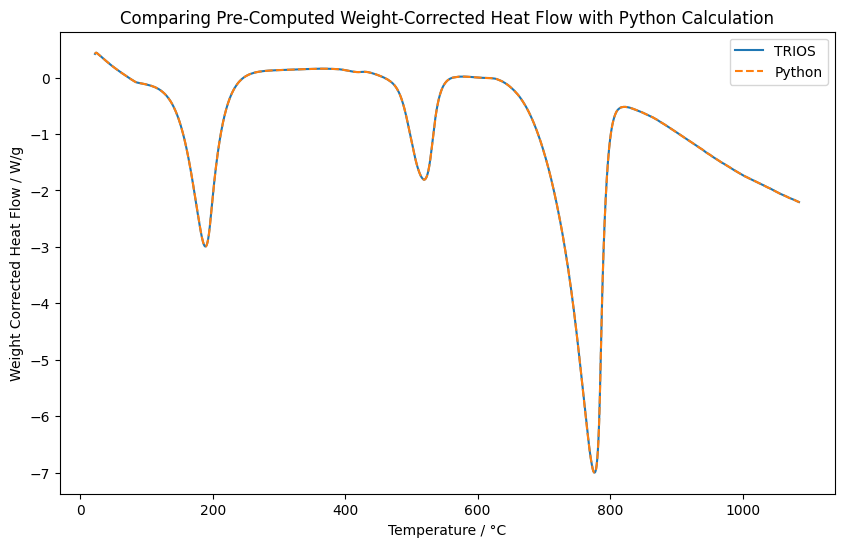

In [2]:
import matplotlib.pyplot as plt

# Calculate weight-corrected heat flow using Python
df["Weight Corrected Heat Flow - Python / W/g"] = (
    df["Heat Flow / mW"] / df["Weight / mg"]
)

# Plot TRIOS and Python calculations for comparison
plt.figure(figsize=(10, 6))
plt.plot(df["Temperature / °C"], df["Weight Corrected Heat Flow / W/g"], label="TRIOS")
plt.plot(
    df["Temperature / °C"],
    df["Weight Corrected Heat Flow - Python / W/g"],
    label="Python",
    linestyle="dashed",
)
plt.xlabel("Temperature / °C")
plt.ylabel("Weight Corrected Heat Flow / W/g")
plt.title("Comparing Pre-Computed Weight-Corrected Heat Flow with Python Calculation")
plt.legend()
plt.show()

## Identification Of Weight Loss Steps

Now, we'll calculate the first derivative of weight to identify regions where the slope plateaus at zero, which indicates weight loss steps.

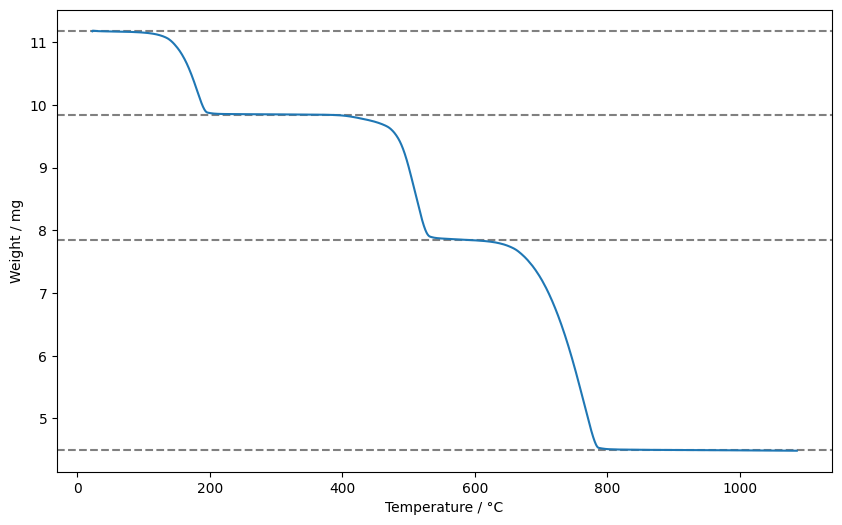

,Start Temperature / °C,End Temperature / °C,Weight Loss / mg,Weight Loss / %
0,22.4,334.5,1.3,11.9
1,334.5,598.4,2.0,17.9
2,598.4,936.2,3.3,29.9


In [3]:
import numpy as np

# Calculate the first derivative of weight with respect to temperature
df["dWeight_dTemp"] = np.gradient(df["Weight / mg"], df["Temperature / °C"])

# Identify plateaus in the derivative
plateau_derivative_threshold = 0.008
plateaus = np.abs(df["dWeight_dTemp"]) < plateau_derivative_threshold

# Find changes in the plateau regions
changes = plateaus.astype(int).diff().dropna()
changes = changes[changes != 0]

# Determine the starting index
starting_idx = df.dropna(subset=["Temperature / °C"]).index[0]

# Initialize weight indices list with the starting index
weight_indices = [starting_idx]

# Identify the indices of weight loss steps
for idx, change_direction in changes.iloc[2:].items():
    if change_direction == 1:
        start_idx = idx
    elif change_direction == -1:
        end_idx = idx
        weight_indices.append(round((end_idx - start_idx) / 2 + start_idx))

# Plot weight loss steps
plt.figure(figsize=(10, 6))
for idx in weight_indices:
    plt.axhline(df["Weight / mg"].iloc[idx], color="grey", linestyle="dashed")
plt.plot(df["Temperature / °C"], df["Weight / mg"])
plt.xlabel("Temperature / °C")
plt.ylabel("Weight / mg")
plt.show()

# Calculate weight loss for each step
weight_steps = (
    df["Temperature / °C"].iloc[weight_indices].to_frame("Start Temperature / °C")
)
weight_steps["End Temperature / °C"] = weight_steps["Start Temperature / °C"]
weight_steps["Start Temperature / °C"] = weight_steps["Start Temperature / °C"].shift(1)
weight_steps["Weight Loss / mg"] = -df["Weight / mg"].iloc[weight_indices].diff()
weight_steps["Weight Loss / %"] = (
    weight_steps["Weight Loss / mg"] / df["Weight / mg"].iloc[weight_indices[0]] * 100
)
weight_steps = weight_steps.iloc[1:].reset_index(drop=True)
weight_steps.round(1)

## Viewing Weight Regimes Overlaid On Heat Flow

We can observe peaks in heat flow at each weight transition.

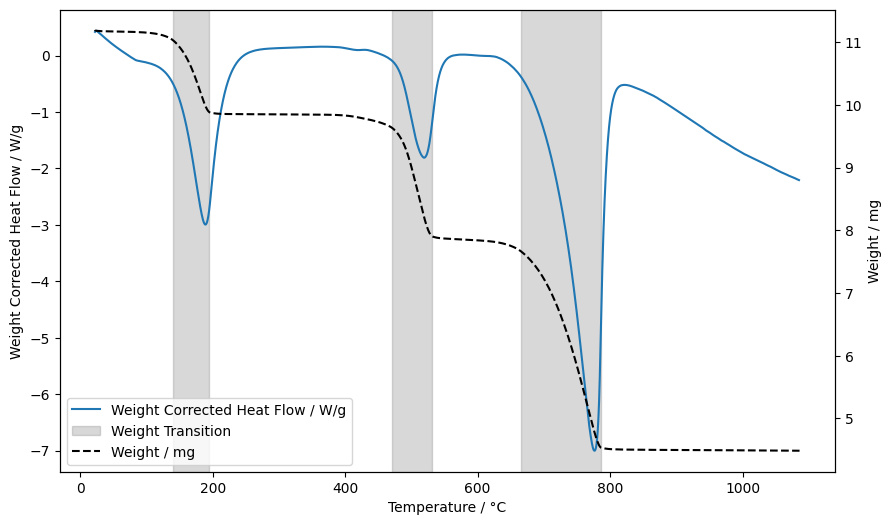

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(
    df["Temperature / °C"],
    df["Weight Corrected Heat Flow / W/g"],
    label="Weight Corrected Heat Flow / W/g",
)
ax1.set_xlabel("Temperature / °C")
ax1.set_ylabel("Weight Corrected Heat Flow / W/g")

# Add weight transitions as shaded regions
for i, (start_idx, end_idx) in enumerate(
    zip(changes[1:-1:2].index, changes[2:-1:2].index)
):
    ax1.axvspan(
        df["Temperature / °C"].iloc[start_idx],
        df["Temperature / °C"].iloc[end_idx],
        color="grey",
        alpha=0.3,
        label="_" * i + "Weight Transition",
    )

# Create a secondary y-axis for weight
ax2 = ax1.twinx()
ax2.plot(
    df["Temperature / °C"],
    df["Weight / mg"],
    color="black",
    linestyle="dashed",
    label="Weight / mg",
)
ax2.set_ylabel("Weight / mg")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower left")
plt.show()

## Using Identified Transition Locations To Quantify Enthalpy From Heat Flow

We'll calculate the smoothed first derivative of the heat flow signal, identify regions where this plateaus outside of the weight transition regions, set the endpoints of our peaks there, subtract a linear baseline, and integrate under each of those peaks to calculate enthalpy.

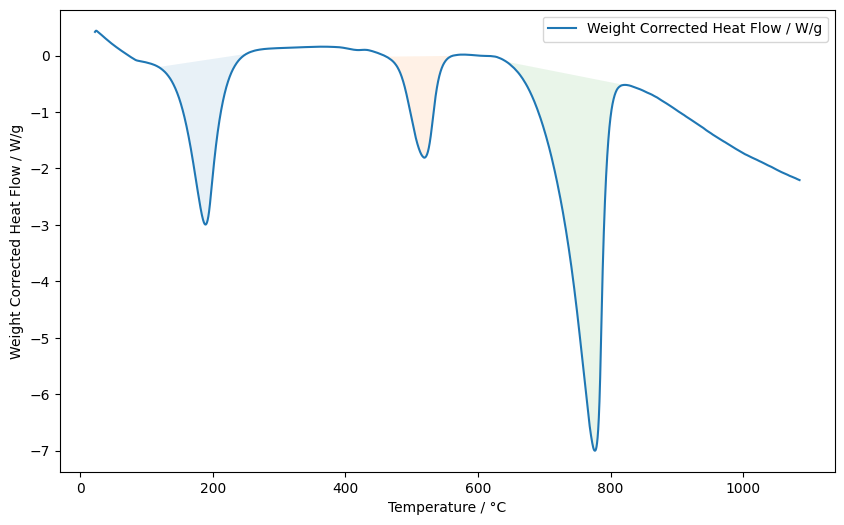

,Start Temperature / °C,End Temperature / °C,Weight Loss / mg,Weight Loss / %,Thermal Start Temperature / °C,Thermal End Temperature / °C,Enthalpy / J/g
0,22.4,334.5,1.3,11.9,118.3,250.8,-402.7
1,334.5,598.4,2.0,17.9,461.8,561.3,-215.5
2,598.4,936.2,3.3,29.9,642.8,820.2,-1129.2


In [7]:
def calculate_enthalpy(data, start_idx, end_idx):
    """Calculate the enthalpy by integrating the area under the curve."""
    peak_data = data.iloc[start_idx:end_idx]
    time_seconds = peak_data["Time / min"] * 60
    heat_flow = peak_data["Weight Corrected Heat Flow / W/g"]
    baseline = np.interp(
        time_seconds,
        [time_seconds.iloc[0], time_seconds.iloc[-1]],
        [heat_flow.iloc[0], heat_flow.iloc[-1]],
    )
    return np.trapz(heat_flow - baseline, time_seconds)


# Calculate the first derivative of weight-corrected heat flow with respect to temperature
df["dWCHF_dTemp"] = np.gradient(
    df["Weight Corrected Heat Flow / W/g"], df["Temperature / °C"]
)

# Smooth it with rolling window
window_size = 1001  # Window size for smoothing
if window_size % 2 == 0:  # Ensure it's odd
    window_size += 1
df["dWCHF_dTemp_smoothed"] = (
    df["dWCHF_dTemp"].rolling(window=window_size, center=True).mean()
)

# Identify plateaus in the smoothed derivative
dWCHF_dTemp_plateau_derivative_threshold = 0.1
dWCHF_dTemp_plateaus = np.abs(df["dWCHF_dTemp_smoothed"]) < plateau_derivative_threshold

# Find changes in the plateau regions
dWCHF_dTemp_changes = dWCHF_dTemp_plateaus.astype(int).diff().dropna()
dWCHF_dTemp_changes = dWCHF_dTemp_changes[dWCHF_dTemp_changes != 0]

# Define regions based on changes in the smoothed derivative
df["dWCHF_dTemp_regions"] = dWCHF_dTemp_changes.abs()
df["dWCHF_dTemp_regions"] = df["dWCHF_dTemp_regions"].fillna(0).cumsum()

# Identify weight and thermal transitions
weight_transitions = []
for idx, change_direction in changes[1:-1].items():
    if change_direction == -1:
        start_idx = idx
    elif change_direction == 1:
        end_idx = idx
        weight_transitions.append((start_idx, end_idx))

thermal_transitions = []
df_by_region = {region: sub_df for region, sub_df in df.groupby("dWCHF_dTemp_regions")}
for start_idx, end_idx in weight_transitions:
    start_region = df["dWCHF_dTemp_regions"].iloc[start_idx] - 1
    thermal_start_idx = df_by_region[start_region].index[-1]
    end_region = df["dWCHF_dTemp_regions"].iloc[end_idx] + 1
    thermal_end_idx = df_by_region[end_region].index[0]
    thermal_transitions.append((thermal_start_idx, thermal_end_idx))

# Calculate enthalpies for each thermal transition
enthalpies = []
for start_idx, end_idx in thermal_transitions:
    enthalpies.append(calculate_enthalpy(df, start_idx, end_idx))

# Plot weight-corrected heat flow and highlight thermal transitions
plt.figure(figsize=(10, 6))
plt.plot(
    df["Temperature / °C"],
    df["Weight Corrected Heat Flow / W/g"],
    label="Weight Corrected Heat Flow / W/g",
)
for start_idx, end_idx in thermal_transitions:
    baseline = np.interp(
        df["Temperature / °C"].iloc[start_idx:end_idx],
        [df["Temperature / °C"].iloc[start_idx], df["Temperature / °C"].iloc[end_idx]],
        [
            df["Weight Corrected Heat Flow / W/g"].iloc[start_idx],
            df["Weight Corrected Heat Flow / W/g"].iloc[end_idx],
        ],
    )
    # plt.plot(
    #     df["Temperature / °C"].iloc[start_idx:end_idx],
    #     baseline,
    # )
    plt.fill_between(
        df["Temperature / °C"].iloc[start_idx:end_idx],
        df["Weight Corrected Heat Flow / W/g"].iloc[start_idx:end_idx],
        baseline,
        alpha=0.1,
    )
plt.xlabel("Temperature / °C")
plt.ylabel("Weight Corrected Heat Flow / W/g")
plt.legend()
plt.show()

# Combine weight steps and thermal transitions into a single DataFrame
thermal_and_weight_steps = weight_steps.copy()
thermal_and_weight_steps["Thermal Start Temperature / °C"] = [
    df["Temperature / °C"].iloc[a] for a, _ in thermal_transitions
]
thermal_and_weight_steps["Thermal End Temperature / °C"] = [
    df["Temperature / °C"].iloc[a] for _, a in thermal_transitions
]
thermal_and_weight_steps["Enthalpy / J/g"] = enthalpies
thermal_and_weight_steps.round(1)